# SIIM-ACR Pneumothorax Segmentation

## Segmentation model ( Part 2 )

In this challenge, the distribution of patient labelled with positive pneumothorax is heavily imbalanced. Since the actual occurrence of pneumothorax in a patient is small, we are not surprised that the majority of the instances are negatives. This will introduce some problem in learning to detect the patient with pneumothorax.

To better handle this task, we decided to split out detection algorithm into 2 stages.

**:: Stage 2 ::**

In this stage, we build a semantic segmentation model that detects and segments pneumothorax from the chest X-ray (8bit unsigned) images. Before training, we perform our image preprocessing similar to how we did in stage 1 where we crop our radiographic images to the region of the chest level by using the bounding boxes we have gotten from the Faster R-CNN. Then, our data generator will carry out over sampling augmentation with 70% of a batchsize being the positive patients.

Next we build a total of four segmentation models with its architecture resembling some structure of modified U-Net with its backbone mainly focuses on EfficientNet B4 and Xception model.

**Our segmentation models built in this section**
>1. U-Net plus plus backed on EfficientNet (with bounding boxes)
>2. U-net plus plus backed on EfficientNet (without bounding boxes)
>3. U-Net backed on Efficient (with bounding boxes)
>4. U-Net plus plus backed on Xception (with bounding boxes)

Lastly, we ensemble our final detection model by stacking the four models we built and we have also added a function at the post processing step where we implemented a conditional random field as we derived our final prediciting mask.

In [2]:
import os
from glob import glob
import tensorflow as tf
import keras
import pandas as pd
import numpy as np

from segment_generator import DataGenerator
from metrics import *

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Configure GPU
os.environ["CUDA_VISIBLE_DEVICES"] = '1, 2, 3' # uncheck to select gpu devices
config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

# Set seed
np.random.seed(609)
tf.set_random_seed(610)

## Load training data and perform train/test split

In [3]:
from sklearn.model_selection import train_test_split
""" Here, we load the classification table 
    since we need the class label to perform oversampling. """

## Loading bounding boxes
bounding_box = pd.read_csv('bounding_box_siim.csv')

## Loading data
data_class = pd.read_csv('train_classification.csv')

## Splitting data into train/valid set (stratified)
trainset, validset = train_test_split(data_class,
                                      test_size=0.20,
                                      stratify=data_class.Label,
                                      random_state=611)

print('*.*.*.*.*.*.* Data class statistics *.*.*.*.*.*.* \n')
print('number of patients in trainset :: ', len(trainset))
print('number of positive patients in trainset :: ', sum(trainset.Label))
print('train positive ratio :: ', sum(trainset.Label)/len(trainset), '\n')

print('number of patients in validset :: ', len(validset))
print('number of positive patients in validset :: ', sum(validset.Label))
print('validation positive ratio :: ', sum(validset.Label)/len(validset))

*.*.*.*.*.*.* Data class statistics *.*.*.*.*.*.* 

number of patients in trainset ::  9667
number of positive patients in trainset ::  2135
train positive ratio ::  0.22085445329471398 

number of patients in validset ::  2417
number of positive patients in validset ::  534
validation positive ratio ::  0.22093504344228382


# Loading data generator and observing the effect of the augmentations

### Design our augmentation processing with albumentations

In [4]:
from albumentations import (Compose, HorizontalFlip, CLAHE, HueSaturationValue,
                            RandomBrightness, RandomContrast, RandomGamma,OneOf,
                            ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
                            RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
                            IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop, Normalize)

## Train augmentation
AUGMENTATIONS_TRAIN = Compose([
    # random horizontal flip
    HorizontalFlip(p=0.5),
    
    # random brightness
    RandomBrightness(p=0.3),
    
    # random contrasting
    OneOf([RandomContrast(limit=0.5),
           CLAHE(clip_limit=2.)], p=0.3),
    
    # random distortion 
    OneOf([ElasticTransform(alpha=120, sigma=100 * 0.16, alpha_affine=100 * 0.04),
           GridDistortion(),
           OpticalDistortion(distort_limit=1.0, shift_limit=0.05),], p=0.25),
    
    # make float32
    ToFloat(max_value=1)], p=1)

## Test augmentation
AUGMENTATIONS_TEST = Compose([
    # make float32
    ToFloat(max_value=1)], p=1)

> ### Data generator with bounding box cropping

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

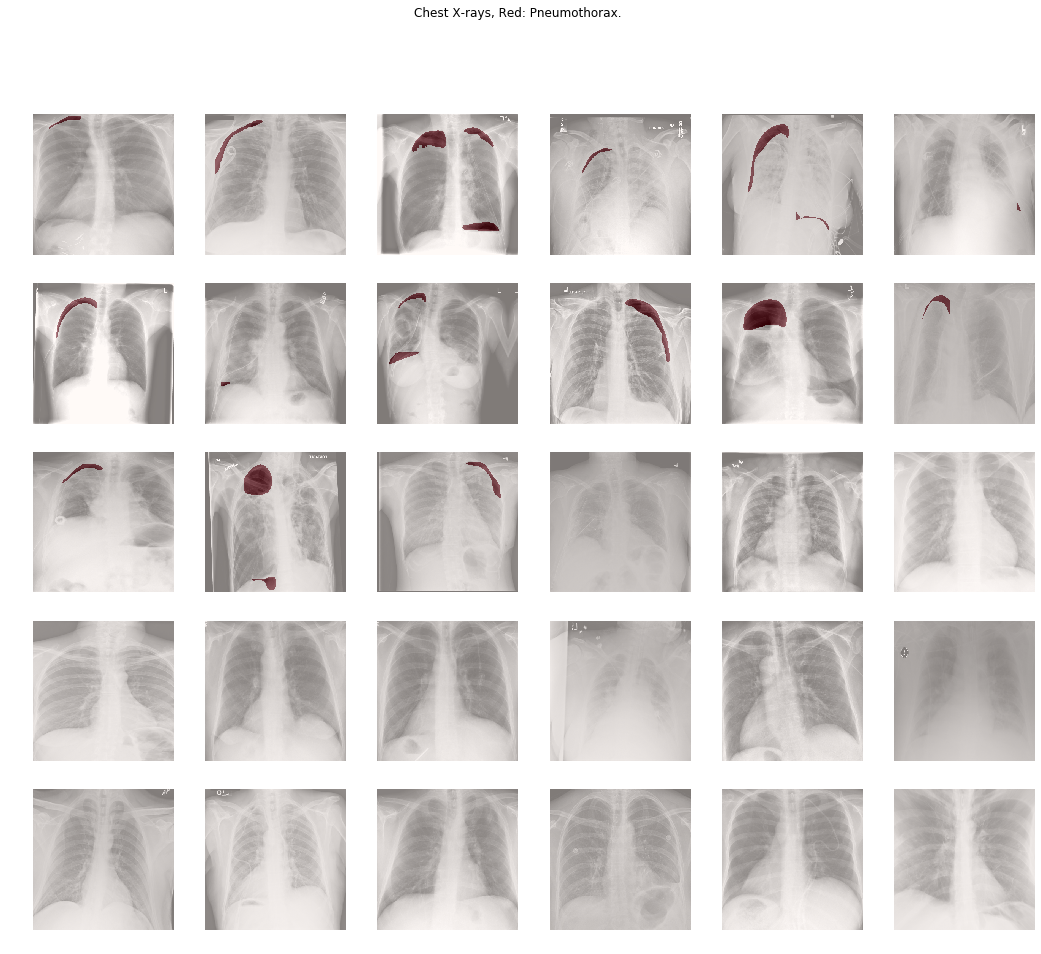

In [5]:
ModelGenerator = DataGenerator(trainset,
                               image_size=512,
                               batch_size=30,
                               augmentation=AUGMENTATIONS_TRAIN, 
                               bounding_box=bounding_box,
                               shuffle=True,
                               ratio=0.5,
                               num_ensemble=None)

images, masks = ModelGenerator.__getitem__(0)
max_images = 30
grid_width = 6
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*3., grid_height*3.))

for i,(im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im.squeeze(), cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

> ### Data generator without bounding box cropping

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

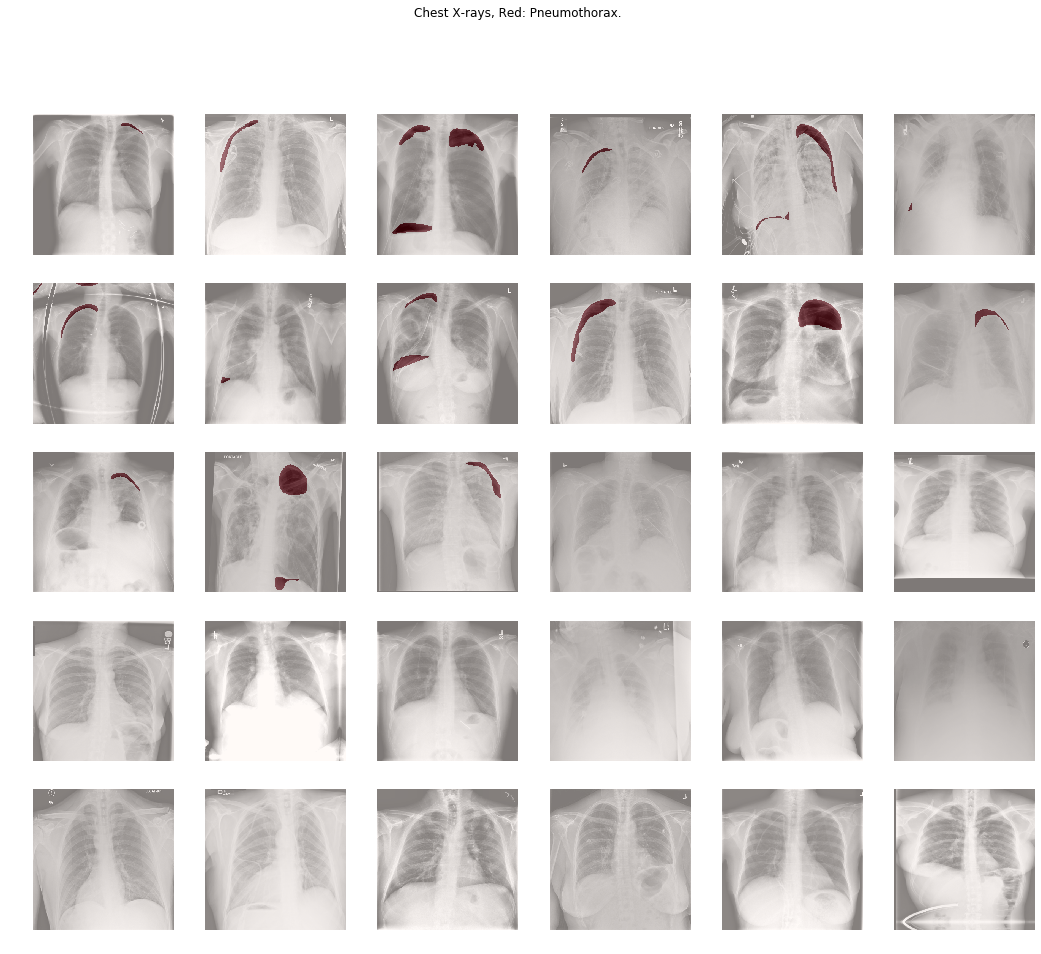

In [6]:
ModelGenerator = DataGenerator(trainset,
                               image_size=512,
                               batch_size=30,
                               augmentation=AUGMENTATIONS_TRAIN, 
                               bounding_box=None,
                               shuffle=True,
                               ratio=0.5,
                               num_ensemble=None)

images, masks = ModelGenerator.__getitem__(0)
max_images = 30
grid_width = 6
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*3., grid_height*3.))

for i,(im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im.squeeze(), cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

# Build Model

In [6]:
# Define model architectures
from models.basics_functions import ModelMGPU
from models.efficientU_Net import UEfficientNet
from models.efficientU_Net_PP import UEfficientNetpp
from models.xceptionU_Net_PP import XceptionNet

## clear session
keras.backend.clear_session()

## Model 1 :: U-Net Backboned on EfficientNet B4 (bounding box crop)
model1 = UEfficientNet(input_shape=(512,512,3), 
                       dropout_rate=0.50)

# ## Model 2 :: U-Net Plus Plus Backboned on EfficientNet B4 
# model2 = UEfficientNetpp(input_shape=(512,512,3),
#                          dropout_rate=0.50)

# ## Model 3 :: U-Net Plus Plus Backboned on EfficientNet B4 (bounding box crop)
# model3 = UEfficientNetpp(input_shape=(512,512,3),
#                          dropout_rate=0.50)

# ## model 4 :: U-Net Plus Plus Backboned on Xception (bounding box crop)
# model4 = XceptionNet(input_shape=(512,512,3),
#                      dropout_rate=0.50)

mode1 = ModelMGPU(model1, 4)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Define training keras callbacks

In [7]:
from keras.callbacks import (ReduceLROnPlateau,
                             ModelCheckpoint,
                             LearningRateScheduler,
                             CSVLogger, 
                             EarlyStopping)

# Define callbacks
def get_callbacks(path):

    # Save checkpoint
    filepath = os.path.join(path,'improved_weights_{epoch:02d}_{val_binary_dice_coeff:.2f}.hdf5')

    checkpointer = ModelCheckpoint(filepath = filepath,
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=True,
                                   monitor = 'val_binary_dice_coeff', 
                                   mode = 'max')

    # Early stopping
    stop_train = EarlyStopping(monitor = 'val_loss',
                               patience=10,
                               verbose=1,
                               mode = 'min')

    # Learning rate scheduling
    schedule_lr = ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.5,
                                    mode = 'min',
                                    patience=1,
                                    min_lr=1e-9,
                                    cooldown=1)

    # CSV logger
    logger = CSVLogger(os.path.join(path,'training_log.csv'))

    # design callbacks
    callback_list = [schedule_lr, stop_train, checkpointer, logger]

    return callback_list

## Setting up environment and train individual selected model

We create folders 
> `segmentation_model1`, `segmentation_model2`, `segmentation_model3` & `segmentation_model4`

to store all our training log records and saved weights for the three different models.

In [ ]:
## set epochs
epochs = 40

## set image size
image_size = 512

## set batch size
batch_size = 12

## learning rate
learning_rate = 3e-4

## model metrics
dice = dice_coeff(1)
sensitivity = pixelwise_sensitivity(1)
specificity = pixelwise_specificity(1)
metrics = [dice,
           my_iou_metric,
           sensitivity,
           specificity]

## set callbacks
callbacks = get_callbacks('segmentation_model1')

## define loss
loss = bce_dice_loss

## compile model
model1.compile(loss=loss,
               optimizer=Adam(lr=learning_rate), 
               metrics=metrics)

## setup data generator
train_generator = DataGenerator(trainset,
                                image_size=image_size,
                                batch_size=batch_size,
                                augmentation=AUGMENTATIONS_TRAIN, 
                                bounding_box=bounding_box,
                                shuffle=True,
                                ratio=0.7,
                                num_ensemble=None)

# we validate with all positive to determine how good our model performs with segmenting pneumothorax
validset_positive =  validset[validset.Label == 1].reset_index(drop = True)
valid_generator = DataGenerator(validset_positive,
                                image_size=image_size,
                                batch_size=batch_size,
                                augmentation=AUGMENTATIONS_TEST, 
                                bounding_box=None,
                                shuffle=True,
                                ratio=None,
                                num_ensemble=None)

## Fit model
model1.fit_generator(generator=train_generator,
                     steps_per_epoch=len(train_generator), 
                     epochs = epochs, verbose=1, 
                     callbacks = callbacks,
                     validation_data=valid_generator,
                     validation_steps=len(valid_generator),
                     max_queue_size=12,
                     workers=12, use_multiprocessing=False)

### Visualisation of model performance

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

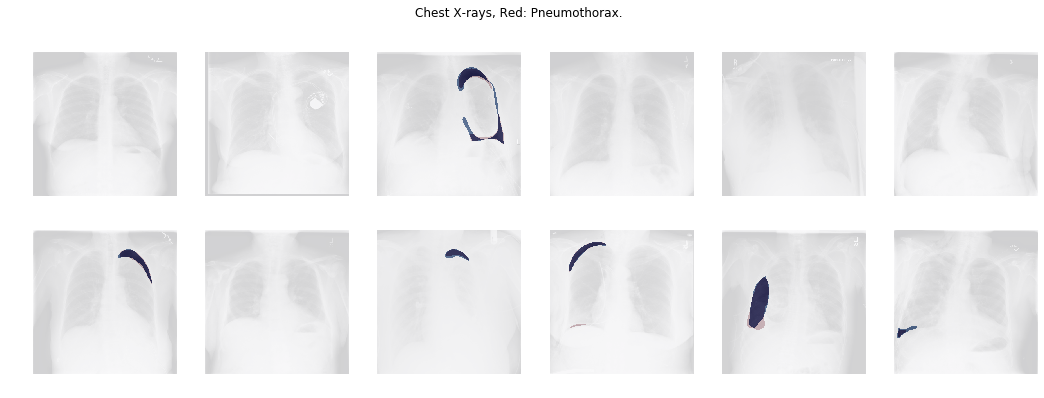

In [10]:
pred_images, target_masks = valid_generator.__getitem__(0)
pred_mask = model_efficient.predict(pred_images)
max_images = batch_size
grid_width = 6
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*3., grid_height*3.))

for i in range(max_images):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(pred_images[i])
    pred_mask_ = (pred_mask[i].squeeze() > 0.5).astype(int)
    ax.imshow(pred_mask_, cmap='Reds',alpha=0.6)
    ax.imshow(target_masks[i].squeeze(), cmap='Blues', alpha = 0.6)    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

# Section 2 :: Ensembling models

In this section, we build an ensembling model with learnable parameters trained with backpropagation. This will connect the predicted semantic map of the four models with additional convolutional layers to process and compress into our final segmentation prediction. In addition, we added a conditional random field by concatenating the input image and setting the convolution layer with a kernel size of 3x3 that will consider t-1, t+1 of the pixel at t. Then, the output is a sigmoid function. Lastly, we will fine-tune the model with multiple epochs.

## Load our trained individual models

In [8]:
# Define model architectures
from models.basics_functions import ModelMGPU
from models.efficientU_Net import UEfficientNet
from models.efficientU_Net_PP import UEfficientNetpp
from models.xceptionU_Net_PP import XceptionNet

## Load models with weights
# model 1
model1 = UEfficientNet(input_shape=(512,512,3), 
                       dropout_rate=0.50)
model1.load_weights('saved_weights/segmentation/model_efficient.hdf5')

# model 2
model2 = UEfficientNetpp(input_shape=(512,512,3),
                         dropout_rate=0.50)
model2.load_weights('saved_weights/segmentation/model_efficientpp_plain.hdf5')

# model 3
model3 = UEfficientNetpp(input_shape=(512,512,3),
                         dropout_rate=0.50)
model3.load_weights('saved_weights/segmentation/model_efficientpp_cropped.hdf5')

# model 4 
model4 = XceptionNet(input_shape=(512,512,3),
                     dropout_rate=0.50)
model4.load_weights('saved_weights/segmentation/model_xceptionpp.hdf5')


candidates = [model1, model2, model3, model4]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Create stacked model

In [9]:
from keras.layers.merge import concatenate
from keras.layers import Input, Conv2D
from keras.models import Model

## Define stacked model from multiple member input models
def define_stacked_model(members):
    
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer.name = 'ensemble_' + str(i+1) + '_' + layer.name
    
    img_input = Input((512,512,3))
    
    # define multi-headed input
    ensemble_visible = [model.input for model in members]
    ensemble_visible.append(img_input)
    
    # concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
    ensemble_outputs.append(img_input)
    merge = concatenate(ensemble_outputs)
    
    # version 1
    conv_init = Conv2D(32,3,activation='relu',padding='same')(merge)
    conv_init = Conv2D(32,3,activation='relu',padding='same')(conv_init)
    
    conv0 = Conv2D(32, 1, activation='relu', padding='same')(conv_init)
    
    conv1 = Conv2D(32, 1, activation='relu', padding='same')(conv_init)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    
    conv2 = Conv2D(32, 1, activation='relu', padding='same')(conv_init)
    conv2 = Conv2D(32, 3, activation='relu', padding='same')(conv2)
    
    conv = concatenate([conv0, conv1, conv2])
    conv = Conv2D(32, 1, activation='relu', padding='same')(conv)
    conv = Conv2D(32, 3, activation='relu', padding='same')(conv)
    conv = Conv2D(32, 3, activation='relu', padding='same')(conv)

#     # version 2 (model weights not included) 
#     conv = Conv2D(32, 1, activation='relu', padding='same')(merge)
#     conv = Conv2D(32, 3, activation='relu', padding='same')(conv)
#     conv = Conv2D(32, 3, activation='relu', padding='same')(conv)
    
    output = Conv2D(1, (1,1), padding="same", activation="sigmoid")(conv) 
    model = Model(inputs=ensemble_visible, outputs=output)

    return model

## Setup environment and train our stack model
We create a folder called `segmentation_stacked_model` to store our training log records and saved weights.

In [ ]:
from keras.optimizers import Adam
# Set num models
num_models = 4

## Set epochs
epochs = 40

## set image size
image_size = 512

## set batch size
batch_size = 32

## learning rate
learning_rate = 3e-4

## define loss
loss = bce_dice_loss

## model metrics
dice = dice_coeff(1)
sensitivity = pixelwise_sensitivity(1)
specificity = pixelwise_specificity(1)
metrics = [dice,
           my_iou_metric,
           sensitivity,
           specificity]

## set callbacks
callbacks = get_callbacks('segmentation_stacked_model')

## build model architecture
stacked_model = define_stacked_model(candidates)
stacked_model = ModelMGPU(stacked_model, 3)

## compile model
stacked_model.compile(loss=loss,
                      optimizer=Adam(lr=learning_rate),
                      metrics=metrics)

## make generator
train_stack_gen = DataGenerator(trainset,
                                image_size=image_size,
                                batch_size=batch_size,
                                augmentation=AUGMENTATIONS_TRAIN, 
                                bounding_box=bounding_box,
                                shuffle=True,
                                ratio=0.7,
                                num_ensemble=num_models)

# we validate with all positive to determine how good our model performs with segmenting pneumothorax
validset_positive =  validset[validset.Label == 1].reset_index(drop = True)
valid_stack_gen = DataGenerator(validset_positive,
                                image_size=image_size,
                                batch_size=batch_size,
                                augmentation=AUGMENTATIONS_TEST, 
                                bounding_box=None,
                                shuffle=True,
                                ratio=None,
                                num_ensemble=num_models)

## Fit model
stacked_model.fit_generator(generator=train_stack_gen,
                            steps_per_epoch=len(train_stack_gen), 
                            epochs = epochs, verbose=1, 
                            callbacks = callbacks,
                            validation_data=valid_stack_gen,
                            validation_steps=len(valid_stack_gen),
                            max_queue_size=12,
                            workers=12, use_multiprocessing=True)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
 32/836 [>.............................] - ETA: 2:22:01 - loss: -14.8282 - binary_dice_coeff: 1.4883 - my_iou_metric: 5.4590 - binary_pixelwise_sensitivity: 0.5561 - binary_pixelwise_specificity: 0.2251

## Load Models and performing visualisation


In [20]:
stacked_model = define_stacked_model(candidates)
stacked_model.load_weights('saved_weights/segmentation/stacked_model.hdf5')

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

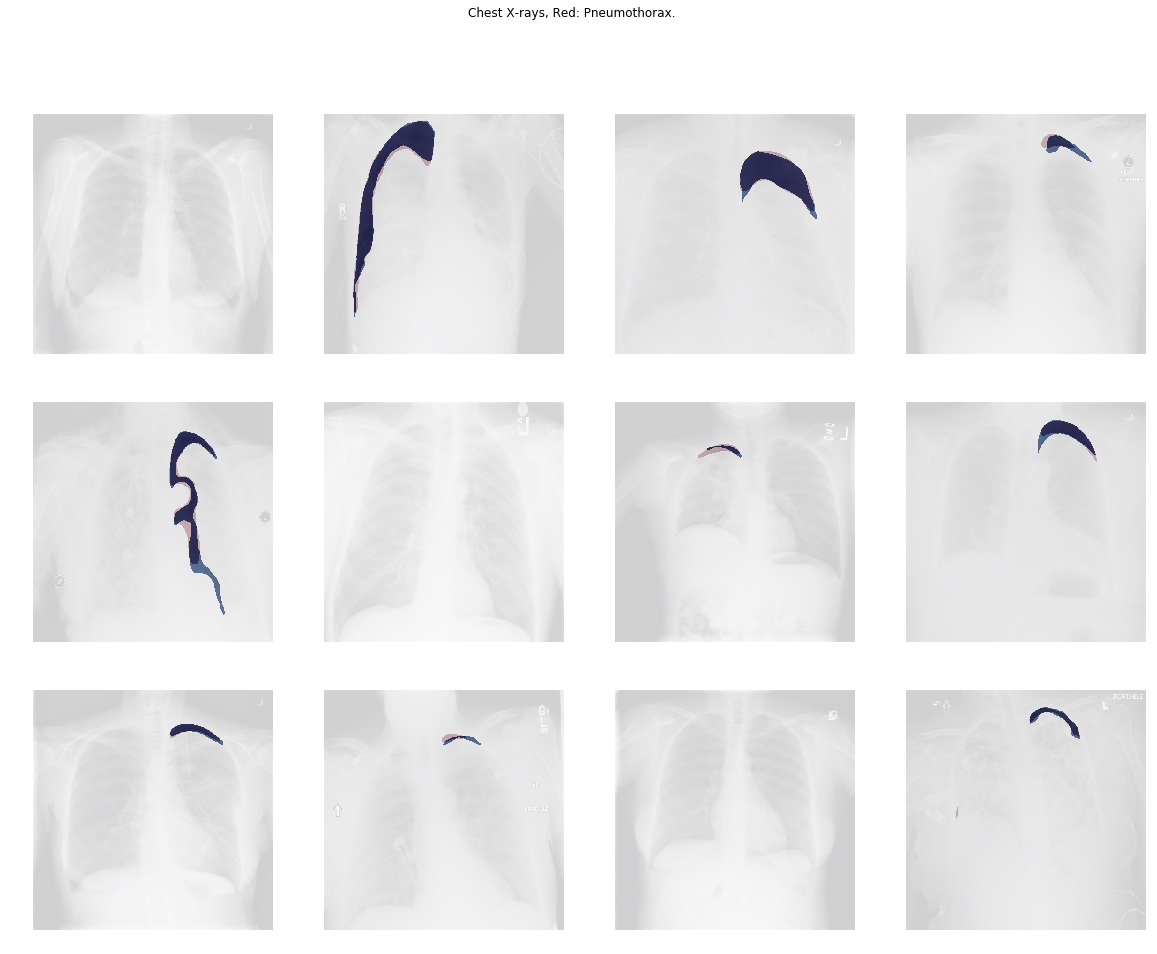

In [14]:
pred_images, target_masks = valid_stackgenerator.__getitem__(5)
pred_mask = stacked_model.predict(pred_images)
max_images = 12
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*5., grid_height*5.))

for i in range(max_images):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(pred_images[0][i])
    pred_mask_ = (pred_mask[i].squeeze() > 0.5).astype(int)
    ax.imshow(pred_mask_, cmap='Reds',alpha=0.6)
    ax.imshow(target_masks[i].squeeze(), cmap='Blues', alpha = 0.6)    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

## Model evaluation 

In [18]:
## Create helper functions for model evaluation

# define prediction function
def predict_result(model,validation_generator,img_size): 
    # TBD predict both orginal and reflect x
    truth, pred = np.empty((0,512,512)), np.empty((0,512,512))
    for i in range(len(valid_generator)):
        pred_images, target_masks = validation_generator.__getitem__(i)
        target_masks = target_masks.reshape(-1,img_size,img_size)
        preds_test1 = model.predict(pred_images).reshape(-1, img_size, img_size)
        truth = np.append(truth, target_masks, axis = 0)
        pred = np.append(pred, preds_test1, axis = 0)
    return truth, pred

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [19]:
## Generate prediction results
target_masks, preds_valid = predict_result(stacked_model,
                                           valid_stackgenerator,
                                           512)

## Scoring for last model
thresholds = np.linspace(0.2, 0.9, 30)
ious = np.array([iou_metric_batch(target_masks,
                                  np.int32(preds_valid > threshold)) for threshold in thresholds])

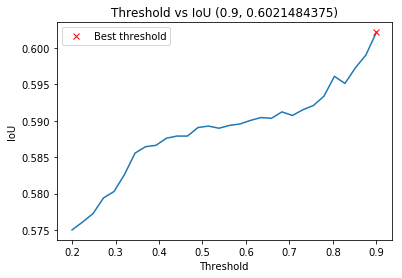

In [22]:
# Plot IoU v.s. threshold to assess imbalance 
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

## Generate predictions

In [ ]:
from glob import glob
test_fn = glob('stage2/*')
x_test = [cv2.resize(np.array(plt.imread(fn)),(512,512)) for fn in test_fn]
x_test = np.array(x_test)
x_test = np.array([np.repeat(im[...,None],3,2) for im in x_test])
print('list of image shape :: ', x_test.shape)

preds_test = np.empty((0,512,512,1))
for i, im in enumerate(x_test):
    imtest = [np.expand_dims(im,axis=0) for _ in range(len(stacked_model.input))]
    # prediction with stacked model
    preds_mask = stacked_model.predict(imtest)
    preds_test = np.append(preds_test, preds_mask, axis=0)


(3205, 512, 512, 3)


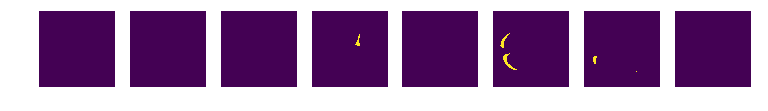

In [31]:
from mask_functions import rle2mask,mask2rle
import pdb

# Generate rle encodings (images are first converted to the original size)
rles = []
i, max_img = 1, 10
plt.figure(figsize=(16,4))

for p in preds_test:
    p = p.squeeze()
    im = cv2.resize(p,(1024,1024))
    im = im > threshold_best
    
    # zero out the smaller regions.
    if im.sum()<1024*2:
        im[:] = 0
    
    im = (im.T*255).astype(np.uint8)  
    rles.append(mask2rle(im, 1024, 1024))
    i += 1
    
    if i<max_img:
        plt.subplot(1,max_img,i)
        plt.imshow(im)
        plt.axis('off')

## Create predictions in submission format

In [32]:
# make submission format
ids = [o.split('/')[-1][:-4] for o in test_fn]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head()

,ImageId,EncodedPixels
0,ID_36ee4f448,-1
1,ID_cafbf4ffb,-1
2,ID_7dd6c9d4c,-1
3,ID_f6044c733,317059 4 1018 7 1016 8 1015 9 1015 9 1014 10 1...
4,ID_609806ebc,-1


In [33]:
# saving file to csv
sub_df.to_csv('stack_seg_ver2.csv', index=False)
sub_df.tail(10)

,ImageId,EncodedPixels
3195,ID_b0e96ee4c,336111 3 1019 6 1016 8 1014 9 1013 11 1011 13 ...
3196,ID_6243413f3,-1
3197,ID_86242dc04,-1
3198,ID_6079d5845,-1
3199,ID_3ece7031b,-1
3200,ID_2892d816e,365849 6 1015 9 1012 12 1009 14 1008 16 1005 1...
3201,ID_7b32caa67,-1
3202,ID_adca2580b,-1
3203,ID_6b8fe08ab,-1
3204,ID_a2e7da171,-1


## Correction on negative classes with classification results

In [34]:
# load csv
sub_df = pd.read_csv('stack_seg_ver2.csv')

# import classification result 
pred_class = pd.read_csv('./stackclass_label2.csv')
pred_class['ImageId'] = [splitext(name)[0] for name in pred_class.image]

# merge file, select negative class and make -1
sub_df = sub_df.merge(pred_class, on='ImageId')
sub_df['Class_pred'] = [i == 0 for i in sub_df.label]
sub_df['EncodedPixels'] = np.where(sub_df.Class_pred,'-1',sub_df.EncodedPixels)

# saving as our submission copy
sub_df.to_csv('stack_seg_final_ver3.csv',columns=['ImageId','EncodedPixels'],index=False)

In [35]:
sub_df.head()

,ImageId,EncodedPixels,image,class_prob,label,Class_pred
0,ID_36ee4f448,-1,ID_36ee4f448.png,0.023437,0,True
1,ID_cafbf4ffb,-1,ID_cafbf4ffb.png,0.027966,0,True
2,ID_7dd6c9d4c,-1,ID_7dd6c9d4c.png,0.102540,0,True
3,ID_f6044c733,317059 4 1018 7 1016 8 1015 9 1015 9 1014 10 1...,ID_f6044c733.png,0.939917,1,False
4,ID_609806ebc,-1,ID_609806ebc.png,0.023497,0,True
